In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import tinyDA as tda

/home/mikkel/.local/lib/python3.8/site-packages/TransportMaps/External.py:54: UserWarning: H5 file support disabled: install h5py if needed.
  warnings.warn("H5 file support disabled: install h5py if needed.")
/home/mikkel/.local/lib/python3.8/site-packages/TransportMaps/External.py:63: UserWarning: pyhmc is not supported: install pyhmc if needed.
  warnings.warn("pyhmc is not supported: install pyhmc if needed.")


In [2]:
def rosenbrock(x, y):
    return (1 - x)**2 + 10*(y - x**2)**2

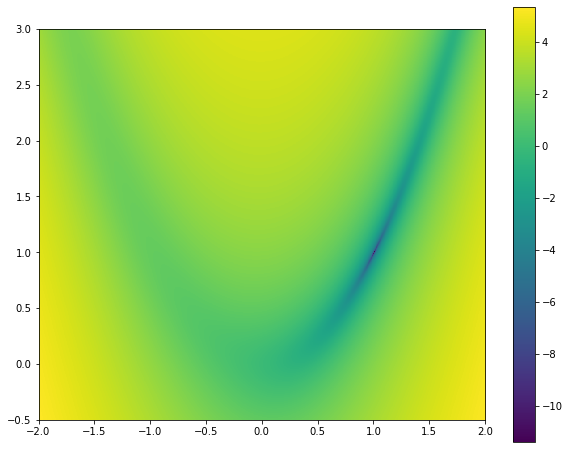

In [3]:
x = np.linspace(-2, 2, 1000); y = np.linspace(-0.5, 3, 1000)
X, Y = np.meshgrid(x,y)
z = rosenbrock(X, Y)

plt.figure(figsize=(10,8))
plt.imshow(np.log(z), origin='lower', extent=(-2, 2, -0.5, 3))
plt.colorbar()

In [4]:
n_par = 2
sigma = 1
data = np.array([0]) + np.random.normal(scale=sigma)

mean_prior = np.zeros(n_par)
cov_prior = np.eye(n_par)
my_prior = multivariate_normal(mean_prior, cov_prior)

cov_likelihood = sigma**2*np.eye(data.shape[0])
my_loglike = tda.LogLike(data, cov_likelihood)

In [5]:
class MyLinkFactory(tda.LinkFactory):
    def evaluate_model(self, parameters):
        output = rosenbrock(parameters[0], parameters[1])
        qoi = None
        return output, qoi

In [6]:
my_link_factory = MyLinkFactory(my_prior, my_loglike)

In [8]:
pcn_scaling = 0.1
pcn_adaptive = True
my_kernel = tda.CrankNicolson(C=cov_prior, scaling=pcn_scaling, adaptive=pcn_adaptive)

gtm_t0 = 2000
gtm_independent = True
my_proposal = tda.GaussianTransportMap(my_kernel, t0=gtm_t0, independence_sampler=gtm_independent)

Loaded TransportMaps v2.0b3


/home/mikkel/OneDrive/Projects/tinyDA/git/tinyDA/proposal.py:465: UserWarning:  GaussianTransportMap is an EXPERIMENTAL proposal. Use with caution.

  warnings.warn(' GaussianTransportMap is an EXPERIMENTAL proposal. Use with caution.\n')


In [9]:
my_chain = tda.Chain(my_link_factory, my_proposal)

In [10]:
my_chain.sample(7000)

Running chain, α = 0.92: 100%|██████████| 7000/7000 [01:52<00:00, 62.25it/s] 


In [11]:
burnin = 2000

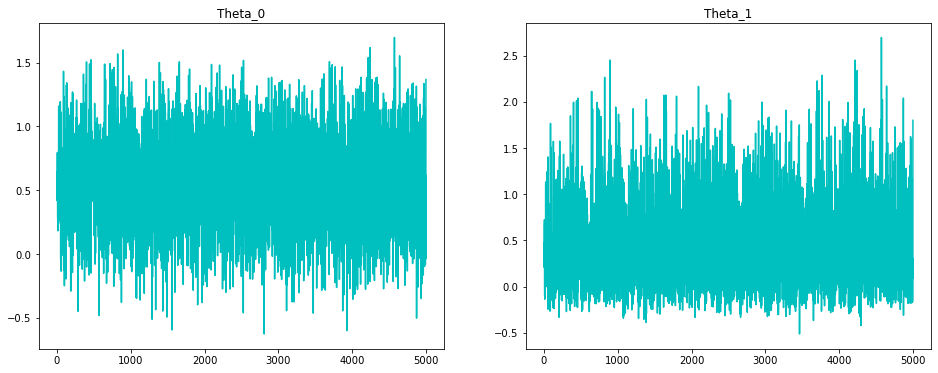

In [12]:
tda.diagnostics.plot_parameters(np.array([link.parameters for link in my_chain.chain]), [0,1], burnin=burnin)

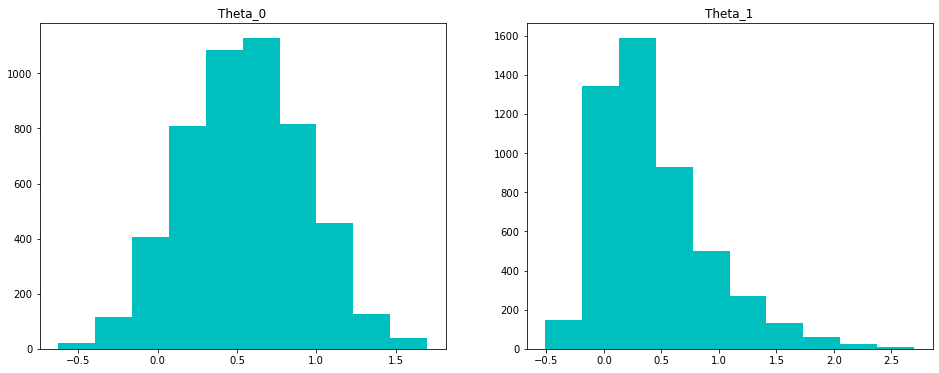

In [13]:
tda.diagnostics.plot_parameters(np.array([link.parameters for link in my_chain.chain]), [0,1], burnin=burnin, plot_type='histogram')

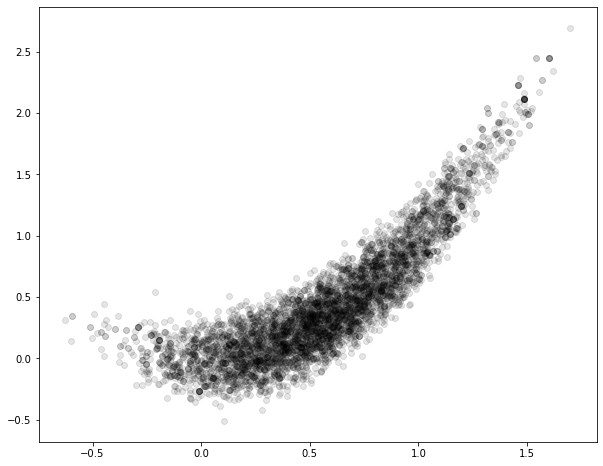

In [17]:
plt.figure(figsize=(10,8))
plt.scatter(np.array([link.parameters[0] for link in my_chain.chain[burnin:]]), np.array([link.parameters[1] for link in my_chain.chain[burnin:]]), c='k', alpha=0.1)
plt.show()

In [15]:
samples = np.random.normal(size=(10000,2))
samples_transformed = my_proposal.T.inverse(samples)

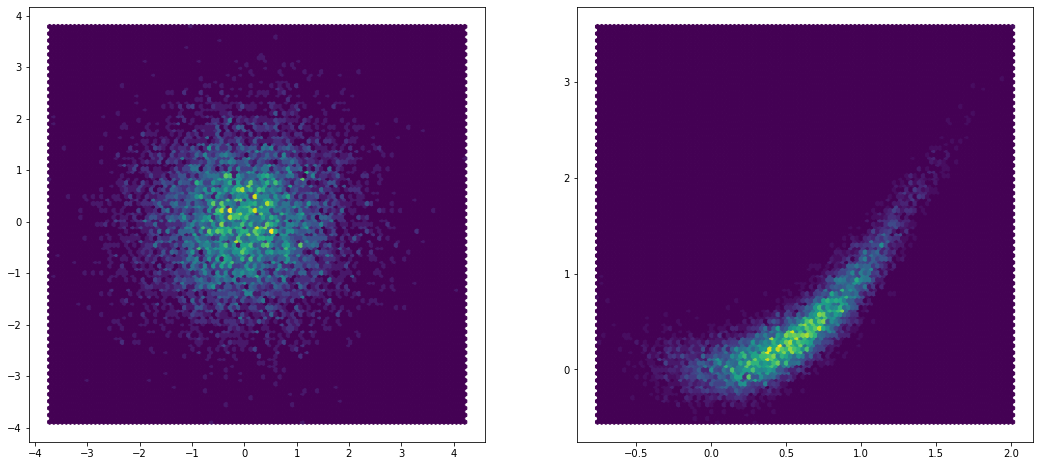

In [16]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.hexbin(samples[:,0], samples[:,1])
plt.subplot(1,2,2)
plt.hexbin(samples_transformed[:,0], samples_transformed[:,1])
plt.show()